I tried Gemma 2B for <b>text highlight</b> (maybe we can say a basic type of text summarization) with <b>zero-shot prompting</b>.

<br>

<span style="color:#e74c3c;"> <b><i> NOTE: This notebook is not efficient in respect of memory allocation. This is why, if you try the model in a row, it can throw errors pertaining to memory.</i></b> </span>

The following methods using in this method.

* one random sample's  'article' and 'highlights' from the train_data and one random sample's  'article' from test_data
* creating a prompt with Gemma tokens [1]

<br>


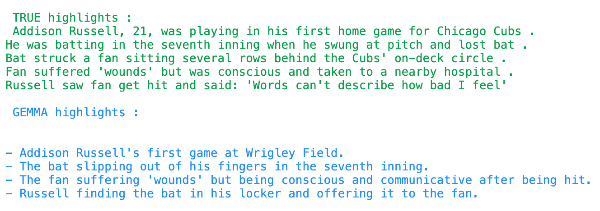

<i>Figure 1: a highlights example</i>


## My Another Projects
* [Malignant Detect w/Deep Multiple Instance Learning](https://www.kaggle.com/code/banddaniel/malignant-detect-w-deep-multiple-instance-learning)
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)


## References
1. https://ai.google.dev/gemma/docs/formatting

In [1]:
from IPython.display import clear_output
!pip install -U keras-nlp
!pip install -U keras
clear_output()

In [2]:
# Importing dependencies

import keras
import keras_nlp

import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import re
from nltk.corpus import  stopwords

import tensorflow as tf

from colorama import Fore, Back, Style

2024-02-26 15:29:56.683029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 15:29:56.683129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 15:29:56.814101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
# reading datasets

train_data = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
test_data = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

# <span style="color:#e74c3c;"> Preprocesing </span>

In [4]:
# basic pre and post processing operations

stop_words = set(stopwords.words('english'))

def text_preprocessing(data):
    data['article'] = data['article'].apply(lambda X: X.lower())
    data['article'] = data['article'].apply(lambda x: x.replace("["," "))
    data['article'] = data['article'].apply(lambda x: x.replace("]"," "))
    data['article'] = data['article'].apply(lambda X: X.replace("''"," "))
    data['article'] = data['article'].apply(lambda X: X.replace("[^A-Za-z]"," "))
    data['article'] = data['article'].apply(lambda X: X.replace("\s+"," "))
    data['article'] = data['article'].apply(lambda X:" ".join([word for word in X.split() if len(word)>1]))
    return data

def last_preprocessing(data):
    data['article'] = data['article'].apply(lambda X:" ".join([word for word in X.split() if word not in stop_words]))
    return data

In [5]:
train_data.head()

,id,article,highlights
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


# <span style="color:#e74c3c;"> GEMMA 2B </span>Model

In [6]:
# import the model

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")

Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [7]:
#  a function for creating a dataframe with random rows

def create_random_dataframe(df, num_prompt = 2):
    articles = []
    highlights = []
    prompts = []
    ids = []
        
    df = df.sample(frac=1).reset_index(drop = True)
    df = df[:num_prompt]
    
    df = text_preprocessing(df)
    df = last_preprocessing(df)
    
    for i in range(num_prompt):
        article = df.iloc[i]['article']
        highlight = df.iloc[i]['highlights']
        
        articles.append(article)
        highlights.append(highlight)
        ids.append(df.iloc[i]['id'])
    
    df = pd.DataFrame({ 'id':ids, 'article': articles, 'highlights': highlights})
    return df

In [8]:
# example data frame for prompt
create_random_dataframe(train_data)

,id,article,highlights
0,77d03953e2ab26f76f22f2dbd8a7bf8f5bf7b265,pet owner kept dogs cages filthy one pets put ...,"Caroline Monk, 45, kept dogs in tiny 'dreadful..."
1,7a84783a2628fed1d86957aa6d010a21911c47cb,(cnn)the desert dun-colored cliffs around town...,"Tataouine, near ""Star Wars"" set, lies just 60 ..."


# <span style="color:#e74c3c;"> Prompt for GEMMA </span> Highlights

In [18]:
def create_prompt_highlight_with_gemma(print_prompt = False):
    train_text_summ_prompts = create_random_dataframe(train_data, 1)
    
    # creating prompt for summarization
    #  1 sample from TRAIN SET (article, highlights)
    #  1 sample from TEST SET (article)
    
    prompt = ''
    for i in range(train_text_summ_prompts.shape[0]):
        prompt = prompt + '<start_of_turn>user\n What are the highlights in this paragraph?: ' + train_text_summ_prompts.iloc[i].article + '<end_of_turn>\n'
        prompt = prompt + '<start_of_turn>model\n the highlights of the paragraph:'+ train_text_summ_prompts.iloc[i].highlights + '<end_of_turn>\n'
        
    # a random sample from the TEST SET
    test_sample = test_data.sample(1)
    prompt = prompt + '<start_of_turn>user\n What are highlights in this paragraph?: ' + test_sample.article.values[0] + '<end_of_turn>\n'
    prompt = prompt + '<start_of_turn>model\n'
    
    true_summarization = test_sample.highlights.values[0]
    
    if print_prompt:
        print(Fore.RED + 'CREATED PROMPT\n',prompt)
        print(Style.RESET_ALL)
    
    # if the prompt has more than 10000 characters, gemma model returns an error about memory (when using gpu)
    # rounding the prompt length to multiples of 1000
    # for example, if the prompt length is 4325, our max_upper_length will be 5000
    max_upper_length = int(np.ceil(len(prompt) / 1000) *1000)
    
    if max_upper_length > 10000:
            print('EXCEED GPU MEMORY, RUN THE FUNCTION AGAIN')
            return
    else:
        summarization = gemma_lm.generate(prompt, max_upper_length)
        gemma_summary = re.split("Sure, here are the highlights of the paragraph:", summarization, maxsplit=0, flags=0)[-1]

    
        print(Fore.GREEN + "\n TRUE highlights : \n", true_summarization)
        print(Fore.BLUE + "\n GEMMA highlights : \n", gemma_summary)
        print(Style.RESET_ALL)
        print('--'*50)

# <span style="color:#e74c3c;"> Examples </span>

In [20]:
try:
    create_prompt_highlight_with_gemma(print_prompt = True)
except tf.errors.ResourceExhaustedError:
    print('run again')

CREATED PROMPT
 <start_of_turn>user
 What are the highlights in this paragraph?: (cnn)the world mexican wrestling wrestling deeply shaken death star fighter hijo del perro aguayo, collapsed kicked bout. lucha libre fighter, whose real name pedro aguayo ramirez, left slumped ropes flying kick one opponents, rey mysterio, match friday night. wrestlers continued fight aguayo's limp body slid onto mat, according video footage bout posted social media. video showed ringside personnel repeatedly shaking aguayo talking without response. eventually received medical attention rushed arena city tijuana. doctors unable revive him. aaa, wrestling promotion company aguayo worked, said informed death around a.m. saturday. 35 years old. "mexican lucha libre mourning death one star talents," aaa said statement. questions remained exactly caused aguayo's death took long receive medical treatment. ernesto franco, duty doctor fight, told mexico's state news agency notimex time aguayo's collapse, attendin

In [15]:
try:
    create_prompt_highlight_with_gemma(print_prompt = False)
except tf.errors.ResourceExhaustedError:
    print('run again')

6000

 TRUE highlights : 
 Sol Campbell has put his flat in Chelsea on the market for £6.75million .
He bought the property in 2011 and it has been renovated by his wife Fiona .
Former England footballer is an outspoken critic of Labour's mansion tax .
Campbell, 40, sold his £20million London townhouse earlier this year .

 GEMMA highlights : 
 

- Alan Shearer is selling a multi-million pound property in Chelsea.


- The property is a former home of Ian Fleming.


- The living room boasts lavish furnishings and marble countertops.


- The kitchen is filled with marble and features gilded mirrors.


- The property is in an exclusive neighborhood and offers stunning views.

----------------------------------------------------------------------------------------------------
